# Binary Classification Model
The goal of this code is to train and compare the performance of three popular classifiers (e.g., Logistic Regression, Random Forests, and Boosting) on a publicly available data set.
Data : The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 
    Goal: Predict " has the client subscribed a term deposit?"

In [1]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pylab as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
import multiprocessing as mp
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline


In [2]:
def roc_auc_rfc(clf,X_test,Y_test):
    target_predict = clf.predict_proba(X_test)
    fpr_rfc, tpr_rfc, _ = roc_curve(Y_test, target_predict[:,1])
    return auc(fpr_rfc, tpr_rfc)
def accuracy(clf,X_test,Y_test):
    target_predict = clf.predict(X_test)
    return metrics.accuracy_score(Y_test, target_predict)

def roc_curve_plot(clfs,clf_names,X_test,Y_test):
    for clf,name in zip(clfs,clf_names):
        target = clf.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(Y_test, target[:,1])
        roc_auc = auc(fpr, tpr)
       
        # plot the roc-auc
        plt.plot(fpr, tpr, label=name +' ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver roc_aucOperating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def precious_recall_plot(clfs,clf_names,X_test,Y_test):
    for clf,name in zip(clfs,clf_names):
        target = clf.predict_proba(X_test)
        precision, recall, _ = precision_recall_curve(Y_test, target[:,1])
        prc_auc = average_precision_score(Y_test, target[:,1])
        plt.plot(recall, precision, label=name+' (area = %0.3f)' % prc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")

    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')        
        

# Reading and preprocessing data
We first start with reading and  pre-processing the data. We need to convert the categorical variables into numbers. We used Label Encoder, which is condense but put varialbes in order with might be misleading as sequantial variables are closer in distance. An alternative would be panda dummies, which is more sparse.
Data Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing


In [3]:
core_count=core_number= mp.cpu_count()
df =pd.read_csv('bank-full.csv',sep=';')

# encode categorical variables
cat_cols = ['job','marital','education','default','loan','contact','day','month','housing','poutcome','y']
for var in cat_cols:
    number = LabelEncoder()
    df[var] = number.fit_transform(df[var].astype('str'))
features = list(df.columns)
features.remove('y')


# Data Exploration and Feature Extraction
The dimension of feature space is not high, yet we start with exploring the data see what features explain the outcome better than others.

# Feature variance
Lets see the variance of each feature variable first

In [4]:
for col in features:
    print col,np.var(df[col])


age 112.755613241
job 10.7100464278
marital 0.369935277624
education 0.559487852211
default 0.0177016286312
balance 9270393.90263
housing 0.246882097546
loan 0.134553964316
contact 0.806298089914
day 78.4670855605
month 9.04131303465
duration 66319.1071777
campaign 9.59752110566
pdays 10025.5440186
previous 5.30572329018
poutcome 0.978216132584


# Univariate Statistical test
We run a one way statistical test for each feature being devided based on the target variable to see if the difference between to divide is statisitcally significant.

In [5]:
sel=GenericUnivariateSelect(f_classif, mode='percentile', param=1e-05)
sel.fit_transform(df[features], df['y'])
features_significance =pd.DataFrame(index=features)
features_significance['score']=sel.scores_
features_significance['p_value']=sel.pvalues_
features_significance = features_significance.sort_values(['score'],ascending=False)
selected_features=features_significance[features_significance.p_value < 0.05].index
print features_significance

                 score        p_value
duration   8333.761148   0.000000e+00
contact    1017.965930  6.396042e-221
housing     892.950576  2.621927e-194
pdays       490.696563  3.790553e-108
previous    396.443989   7.801830e-88
poutcome    275.596872   1.042629e-61
campaign    243.358404   1.012347e-54
loan        211.167395   9.793658e-48
education   199.242825   3.811335e-45
balance     126.572276   2.521114e-29
marital      94.150026   3.074847e-22
job          74.048351   7.863489e-18
age          28.625233   8.825644e-08
month        27.089689   1.950782e-07
day          25.628941   4.154078e-07
default      22.733923   1.866327e-06


# Enthropy Based Feature Extraction
Another way of feature selection is based on tree-based classifiers. Since in tree-based classifers, decision trees are used to divide the data to incrase impurity, the features that are mostly selected for dividing the data should be more informative. 
We use ExtraTreesclassifiers mainly because they are cheaper to train. 
We used all features and did not do a dimension reduction transformation (e.g., PCA) as the size of the data can easily be handled.

Feature ranking:
           Importance       Std
duration     0.256916  0.004694
age          0.100084  0.006413
month        0.093337  0.007062
day          0.091860  0.002536
balance      0.091534  0.005131
job          0.061027  0.002116
campaign     0.058466  0.004033
poutcome     0.057689  0.012007
pdays        0.044412  0.011173
education    0.037936  0.005151
housing      0.025778  0.008704
marital      0.023782  0.007461
contact      0.023444  0.003044
previous     0.022209  0.004288
loan         0.008608  0.002603
default      0.002918  0.000900


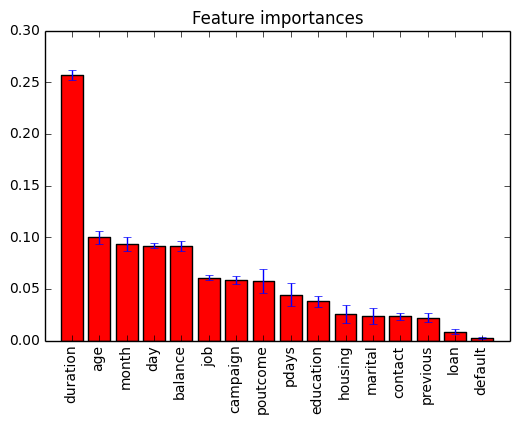

In [14]:
clf_ExtraTrees = ExtraTreesClassifier()
clf_ExtraTrees = clf_ExtraTrees.fit(df[features], df['y'])
importances = clf_ExtraTrees.feature_importances_
importance = pd.DataFrame(importances, index=features, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in clf_ExtraTrees.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

importance= importance.sort_values(['Importance'],ascending=[False])

# Print the feature ranking
print("Feature ranking:")
print importance
# Plot the feature importances of the forest
fig=plt.figure()
plt.title("Feature importances")

plt.bar(range(df[features].shape[1]), importance["Importance"],
       color="r", yerr=importance["Std"], align="center")
plt.xticks(range(df[features].shape[1]), importance.index,rotation=90)
plt.xlim([-1, df[features].shape[1]])
plt.show()

In [7]:
X_train, X_test, Y_train, Y_test  = train_test_split(df[features], 
                                                     df['y'], test_size=0.2, random_state=20)

# Logistic Regression
As the baseline, we use Logistic Regression

In [8]:
clf_Logit = LogisticRegression()
clf_Logit.fit(X_train, Y_train)
print 'roc_auc: ',roc_auc_rfc(clf_Logit,X_test,Y_test)
print 'accuracy score:', accuracy(clf_Logit,X_test,Y_test)


roc_auc:  0.877941955696
accuracy score: 0.893840539644


# Random Forests
Random forests often outperform LR models. They are quaite robust to missing values, irrelevant features, and outliers. They do not need that much tuning and their paramters are streight forward (e.g., larger number of estimators improve the accuracy, and there is not much difference between different criteria)

In [9]:
clf_RFC = RandomForestClassifier(n_estimators=1000,
                             max_features='auto',
                             n_jobs=core_count)
clf_RFC = clf_RFC.fit(X_train, Y_train)

print 'roc_auc: ',roc_auc_rfc(clf_RFC,X_test,Y_test)
print 'accuracy score:', accuracy(clf_RFC,X_test,Y_test)


roc_auc:  0.932039085445
accuracy score: 0.908326882672


# Gradient Boosting
Gradient Boosting often slightly outperform RFCs, yet their hyper paramters are more diffult to tune. We used Gridsearch and cross validaiton to tune the paramaters to show how this could be done. This can further be improved though.
The detail of tuning GBM can be found at: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [10]:
param_test1 = {'n_estimators':range(20,200,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=core_count,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_


({'n_estimators': 190}, 0.9302079087099463)

In [11]:
#Grid seach on subsample and max_features
param_test2 = {'max_depth':range(5,20,2), 'min_samples_split':range(100,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.best_params_, gsearch1.best_score_

({'max_depth': 19, 'min_samples_split': 300}, 0.9302079087099463)

In [12]:
#Grid seach on subsample and max_features
param_test3 = {'min_samples_split':range(500,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,
                                                    max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 30, 'min_samples_split': 500}, 0.92729655466361294)

In [13]:
param_test4 = {'max_features':range(2,8,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, 
                            min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_, gsearch3.best_score_

({'max_features': 6}, 0.92729655466361294)

In [14]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, 
                            min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10, max_features=7),
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,Y_train)
gsearch5.best_params_, gsearch3.best_score_

({'subsample': 0.85}, 0.92729655466361294)

In [15]:
clf_GBM= GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,max_depth=16, min_samples_split=1000, 
                                         min_samples_leaf=50, subsample=0.85, random_state=10, max_features=7,
                                         warm_start=True)
clf_GBM = clf_GBM.fit(X_train, Y_train)

print 'roc_auc: ',roc_auc_rfc(clf_RFC,X_test,Y_test)
print 'accuracy score:', accuracy(clf_RFC,X_test,Y_test)

roc_auc:  0.932039085445
accuracy score: 0.908326882672


# Comparing the Performance of Classifiers
# ROC Curve
An ideal classifier would stick to (1,0) with auc=1, a random classifer would be the line from (0,0) to (1,1).

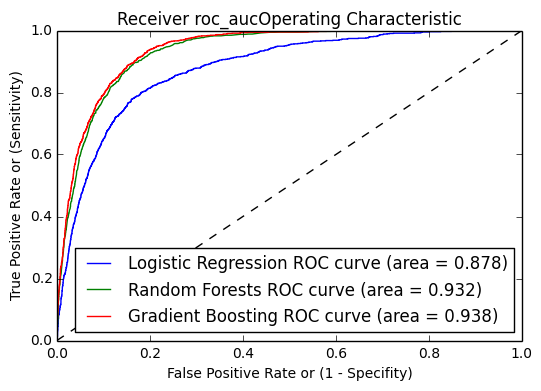

In [16]:
clfs=[clf_Logit,clf_RFC,clf_GBM]
clfs_names=['Logistic Regression','Random Forests','Gradient Boosting']
roc_curve_plot(clfs,clfs_names,X_test,Y_test)


# Precisiou-Recall Curve
A high preciuos low recall classier would detect few positive most of which have been classified correctly. A low preciuos high recall classifier would detect a large number of positive many of which have been missclassified. 
Ideally a perfect classifier is high recall high preciouse. However, the trade-off between precious recall depend on the applicaiton. For example, for spam detect we want to have high precious ( we don't want our important emails being mistakenly transferred to spam folder). However, for detecting a HIV we need to have a high recall classifier, so we do not miss any probable positive case. 

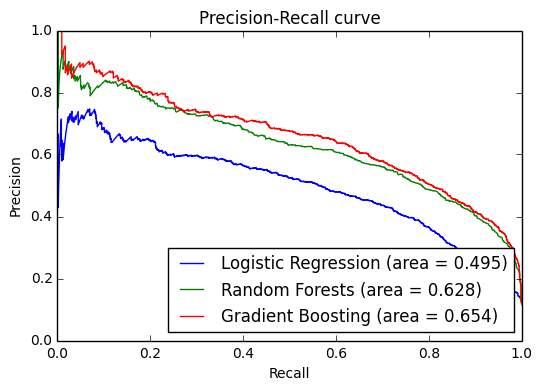

In [17]:
precious_recall_plot(clfs,clfs_names,X_test,Y_test)

# Confusion Matrix

Confusion matrix, without normalization
[[7748  248]
 [ 528  519]]


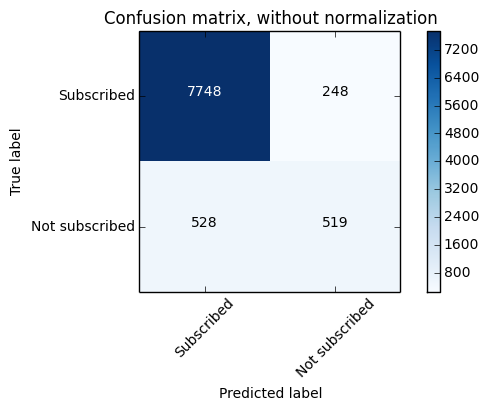

In [18]:
Y_pred=clf_GBM.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Subscribed','Not subscribed'],
                      title='Confusion matrix, without normalization')
